In [142]:
import math
import random
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
from bertopic import BERTopic
from tqdm import tqdm
import json

import nltk
import spacy
import re
import string
from typing import List, Iterable
from nltk.corpus import stopwords 

from transformers import AutoTokenizer, AutoModelForCausalLM
import torch
import json
from jsonformer import Jsonformer


In [147]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/vitaly/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/vitaly/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/vitaly/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

In [53]:
df = pd.read_json('../data/arxiv-metadata-oai-snapshot.json', lines=True, chunksize=1_000)

In [54]:
chunk = next(df)
chunk.head(2)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"


# Unique categories of abstracts

In [55]:
unique_categories = [xx for x in chunk.categories.values for xx in x.split(' ')]
Counter(unique_categories)

Counter({'astro-ph': 208,
         'hep-th': 89,
         'hep-ph': 80,
         'quant-ph': 67,
         'cond-mat.mtrl-sci': 56,
         'gr-qc': 55,
         'cond-mat.str-el': 55,
         'cond-mat.mes-hall': 50,
         'cond-mat.stat-mech': 47,
         'math-ph': 35,
         'math.MP': 35,
         'nucl-th': 32,
         'cond-mat.other': 29,
         'cond-mat.supr-con': 29,
         'math.CO': 25,
         'math.AG': 25,
         'math.PR': 25,
         'hep-ex': 24,
         'physics.optics': 24,
         'cond-mat.soft': 23,
         'math.AP': 21,
         'nucl-ex': 20,
         'cond-mat.dis-nn': 19,
         'physics.gen-ph': 18,
         'math.DG': 18,
         'cs.IT': 17,
         'math.IT': 17,
         'math.CA': 15,
         'math.RT': 14,
         'math.CV': 13,
         'math.NT': 12,
         'math.QA': 12,
         'physics.soc-ph': 12,
         'physics.data-an': 12,
         'physics.comp-ph': 11,
         'math.ST': 11,
         'stat.TH': 11,
         

# Preprocessing

In [ ]:
EMAIL_REGEX = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b")
HTML_TAG_REGEX = re.compile(r"<.*?>")
PUNCT_TABLE = str.maketrans("", "", string.punctuation)

def remove_stopwords(text: str) -> str:
    """
    Remove stopwords from a text.
    """
    stop_words = set(stopwords.words("english"))
    tokens = text.split()
    filtered = [t for t in tokens if t.lower() not in stop_words]
    return " ".join(filtered)

def remove_emails_and_html(text: str) -> str:
    """
    Remove email addresses and HTML tags from a text.
    """
    no_emails = EMAIL_REGEX.sub(" ", text)
    no_html = HTML_TAG_REGEX.sub(" ", no_emails)
    no_html = re.sub(r"\s+", " ", no_html).strip()
    return no_html

def remove_punctuation(text: str) -> str:
    """
    Remove all punctuation characters from a text.
    """
    return text.translate(PUNCT_TABLE)

def filter_short_docs(docs: List[str], min_tokens: int = 5) -> List[str]:
    """
    Keep only documents that have at least `min_tokens` tokens.
    """
    filtered = []
    for doc in docs:
        n_tokens = len(doc.split())
        if n_tokens >= min_tokens:
            filtered.append(doc)
    return filtered

def lemmatize_text(text: str) -> str:
    """
    Lemmatize text using spaCy.
    
    python -m spacy download en_core_web_sm

    Returns a space-joined string of lemmas.
    """
    nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

    doc = nlp(text)
    lemmas = [token.lemma_ for token in doc if not token.is_space]
    return " ".join(lemmas)

def preprocess_text(text: str) -> str:
    text = remove_emails_and_html(text)
    text = remove_punctuation(text)
    text = text.lower()
    text = remove_stopwords(text)
    text = lemmatize_text(text)
    return text

In [150]:
chunk['abstract_post'] = chunk['abstract'].apply(lambda x: preprocess_text(x))

# BERTopic

In [152]:
topic_model = BERTopic.load("MaartenGr/BERTopic_Wikipedia")
topic, prob = topic_model.transform(chunk.abstract_post.values)

Batches: 100%|██████████| 32/32 [00:04<00:00,  6.56it/s]
2025-12-02 18:14:06,227 - BERTopic - Predicting topic assignments through cosine similarity of topic and document embeddings.
/Users/vitaly/Documents/Github/iris/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: divide by zero encountered in matmul
  ret = a @ b
/Users/vitaly/Documents/Github/iris/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: overflow encountered in matmul
  ret = a @ b
/Users/vitaly/Documents/Github/iris/venv/lib/python3.9/site-packages/sklearn/utils/extmath.py:203: RuntimeWarning: invalid value encountered in matmul
  ret = a @ b


# Example of BERTopic output

In [153]:
text_id = 10
topic_id = topic[text_id]
text = chunk.abstract.values[text_id]

print('Abstract')
print(text)

print('Cluster label')
print(topic_model.topic_labels_[topic_id])
print()

print('Top words')
print(topic_model.get_topic(topic_id))

Abstract
  In this paper we present an algorithm for computing Hecke eigensystems of
Hilbert-Siegel cusp forms over real quadratic fields of narrow class number
one. We give some illustrative examples using the quadratic field
$\Q(\sqrt{5})$. In those examples, we identify Hilbert-Siegel eigenforms that
are possible lifts from Hilbert eigenforms.

Cluster label
18_matrices_matrix_transpose_eigenvector

Top words
[['matrices', 0.6521367430686951], ['matrix', 0.6065698862075806], ['transpose', 0.39497610926628113], ['eigenvector', 0.37739312648773193], ['multiplication', 0.3743625283241272], ['eigenvectors', 0.35193151235580444], ['columns', 0.3202955722808838], ['tensors', 0.3159672021865845], ['quaternions', 0.3140992224216461], ['determinants', 0.31085848808288574]]


# LLM model

In [60]:
schema = {
    "type": "object",
    "properties": {
        "hight_level_topic": {"type": "string"},
        "low_level_topic": {"type": "string"},
    },
    "required": ["hight_level_topic", "low_level_topic"],
}

model_name = "Qwen/Qwen2.5-3B"                

tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",             
    trust_remote_code=True
)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
Loading checkpoint shards: 100%|██████████| 2/2 [00:19<00:00,  9.80s/it]
Some parameters are on the meta device because they were offloaded to the disk.


In [66]:
def get_prompt(top_words, text):
    prompt = f"""
        These are the keywords of a group of scientific articles: {top_words}.

        This is an example of the abstract of one article in this group:
        {text}

        What are the high- and low-level topics of this group of articles?

        You must fill:
        - hight_level_topic (string)
        - low_level_topic (string)

        hight_level_topic is a general scientific discipline like Mathematics, Physics, Medicide and so on.
        low_level_topic is a specific subtopic of the defined scientific discipline.

        Return ONLY the structured data.
    """
    return prompt

In [67]:
text_id = 10
topic_id = topic[text_id]
text = chunk.abstract.values[text_id]
top_words = topic_model.get_topic(topic_id)

prompt = get_prompt(top_words, text)

generator = Jsonformer(
    model=model,
    tokenizer=tokenizer,
    json_schema=schema,
    prompt=prompt,
    max_array_length=10,
    max_number_tokens=5,
)

raw_result = generator()
print("LLM response:", json.dumps(raw_result, indent=2))

LLM response: {
  "hight_level_topic": "Mathematics",
  "low_level_topic": "Number theory"
}


In [158]:
topic_words = topic_model.get_topics()
representative_texts = dict() 

for topic_id, _ in tqdm(topic_words.items()):
    if sum(topic==topic_id) > 0:
        representative_texts[topic_id] = random.choice(chunk.abstract.values[topic==topic_id])
    else:
        representative_texts[topic_id] = ""

100%|██████████| 2377/2377 [00:00<00:00, 23056.13it/s]


In [159]:
prediction = dict()
for topic_id, text in tqdm(representative_texts.items()):
    top_words = [x for x in topic_words[topic_id]]

    prompt = get_prompt(top_words, text)

    generator = Jsonformer(
        model=model,
        tokenizer=tokenizer,
        json_schema=schema,
        prompt=prompt,
        max_array_length=10,
        max_number_tokens=5,
    )

    raw_result = generator()

    prediction[topic_id] = raw_result

  8%|▊         | 194/2377 [33:33<6:17:39, 10.38s/it]


KeyboardInterrupt: 

In [80]:
with open('../data/title_prediction.json', 'w') as f:
    json.dump(prediction, f)

In [82]:
text_id = 10
topic_id = topic[text_id]
text = chunk.abstract.values[text_id]
title = prediction[topic_id]

print('Abstract')
print(text)

print('Cluster label')
print(topic_model.topic_labels_[topic_id])
print()

print('Top words')
print(topic_model.get_topic(topic_id))
print()

print('Title prediction')
print(prediction[topic_id])

Abstract
  In this paper we present an algorithm for computing Hecke eigensystems of
Hilbert-Siegel cusp forms over real quadratic fields of narrow class number
one. We give some illustrative examples using the quadratic field
$\Q(\sqrt{5})$. In those examples, we identify Hilbert-Siegel eigenforms that
are possible lifts from Hilbert eigenforms.

Cluster label
834_integers_primes_integer_prime

Top words
[['integers', 0.5680645704269409], ['primes', 0.5572009086608887], ['integer', 0.484574556350708], ['prime', 0.47240108251571655], ['arithmetic', 0.4225975275039673], ['multiplicative', 0.42088091373443604], ['divisors', 0.39332306385040283], ['divides', 0.3841027021408081], ['numbers', 0.360837459564209], ['divisibility', 0.3401588201522827]]

Title prediction
{'hight_level_topic': 'Mathematics', 'low_level_topic': 'Number theory'}


# Validation

In [154]:
def concentration_score(counts: dict[str, int]) -> float:
    values = list(counts.values())
    K = len(values)

    if K == 1:
        return 1.0

    total = sum(values)
    if total == 0:
        return 0.0

    ps = [v / total for v in values if v > 0]

    H = -sum(p * math.log(p) for p in ps)
    H_norm = H / math.log(K)

    return 1.0 - H_norm

In [155]:
chunk['high_level_categories'] = chunk.categories.apply(lambda x: set([xx.split('.')[0] for xx in x.split(' ')]))
chunk['high_level_categories'] = chunk['high_level_categories'].apply(lambda x: [xx.split('-', 1)[1] if '-' in xx else xx for xx in x])
chunk['high_level_categories']

0            [ph]
1      [cs, math]
2       [physics]
3          [math]
4          [math]
          ...    
995          [th]
996        [math]
997        [math]
998        [math]
999          [ex]
Name: high_level_categories, Length: 1000, dtype: object

In [156]:
metrics = []
for label in tqdm(np.unique(topic)):
    mask = topic == label
    categories_count = Counter([xx for x in chunk.loc[mask, 'high_level_categories'].values for xx in x])
    metrics.append(concentration_score(categories_count))

100%|██████████| 174/174 [00:00<00:00, 4823.72it/s]


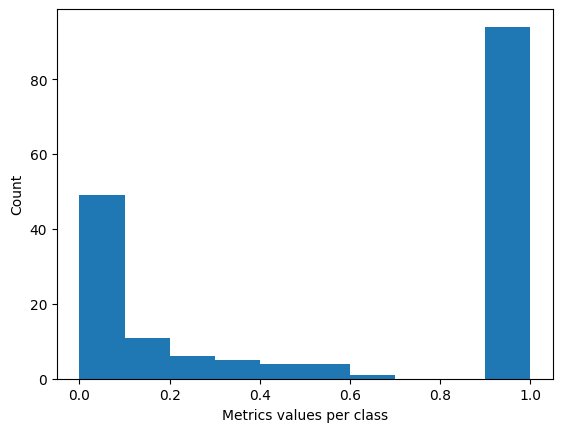

In [162]:
plt.hist(metrics)
plt.xlabel('Metrics values per class')
plt.ylabel('Count')
plt.show()

In [160]:
# sport_article = ["""
# A popular quantitative approach to evaluating player performance in sports involves comparing an observed outcome to the expected outcome ignoring player involvement, which is estimated using statistical or machine learning methods. In soccer, for instance, goals above expectation (GAX) of a player measure how often shots of this player led to a goal compared to the model-derived expected outcome of the shots. Typically, sports data analysts rely on flexible machine learning models, which are capable of handling complex nonlinear effects and feature interactions, but fail to provide valid statistical inference due to finite-sample bias and slow convergence rates. In this paper, we close this gap by presenting a framework for player evaluation with metrics derived from differences in actual and expected outcomes using flexible machine learning algorithms, which nonetheless allows for valid frequentist inference. We first show that the commonly used metrics are directly related to Rao's score test in parametric regression models for the expected outcome. Motivated by this finding and recent developments in double machine learning, we then propose the use of residualized versions of the original metrics. For GAX, the residualization step corresponds to an additional regression predicting whether a given player would take the shot under the circumstances described by the features. We further relate metrics in the proposed framework to player-specific effect estimates in interpretable semiparametric regression models, allowing us to infer directional effects, e.g., to determine players that have a positive impact on the outcome. Our primary use case are GAX in soccer. We further apply our framework to evaluate goal-stopping ability of goalkeepers, shooting skill in basketball, quarterback passing skill in American football, and injury-proneness of soccer players.
# """]

# sport_topic, sport_prob = topic_model.transform(sport_article)
# topic_id = sport_topic[0]

# print('Abstract')
# print(sport_article)

# print('Cluster label')
# print(topic_model.topic_labels_[topic_id])
# print()

# print('Top words')
# print(topic_model.get_topic(topic_id))
# print()

# print('Title prediction')
# print(prediction[topic_id])